In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import dynamo
import dynamo as dyn
from dynamo.preprocessing import Preprocessor
import pearson_residual_normalization_recipe
from benchmark_utils import *
from SCTransform import SCTransform

adata_origin = dyn.sample_data.zebrafish()

|-----> Downloading data to ./data/zebrafish.h5ad


## Convert and Output Data for R Seurat inputs

## sample preprocessor code  


In [2]:
def preprocess_dyn_sctransform_result_adata():
    from dynamo.preprocessing import Preprocessor
    adata = dyn.sample_data.zebrafish()
    preprocessor = Preprocessor()
    preprocessor.config_monocle_recipe(adata)
    preprocessor.normalize_by_cells = None
    preprocessor.select_genes_function = dyn.preprocessing.select_genes_by_dispersion_svr
    # preprocessor.select_genes_function = pearson_residual_normalization_recipe.select_genes_by_pearson_residual
    # preprocessor.normalize_selected_genes_function = pearson_residual_normalization_recipe.normalize_layers_pearson_residuals
    dyn.preprocessing.unique_var_obs_adata(adata)
    preprocessor.filter_cells_by_outliers(adata, keep_filtered=False)
    preprocessor.filter_genes_by_outliers(adata, inplace=True, min_cell_s=5)
    preprocessor.select_genes(adata, n_top_genes=2000)
    adata = adata[:, adata.var["use_for_pca"]]

    print("data before sctransform:")
    print(pd.DataFrame(adata.X.data).describe())
    SCTransform(adata, inplace=True)
    print("data after sctransform:")
    print(pd.DataFrame(adata.X.data).describe())
    preprocessor.use_log1p = False
    # preprocessor.preprocess_adata(adata)
    preprocessor.pca(adata, n_pca_components=50, pca_key="X_pca")
    dyn.data_io.cleanup(adata)
    adata.write_h5ad("./data/zebrafish_sctransform_preprocessor.h5ad")

preprocess_dyn_sctransform_result_adata()

|-----> Downloading data to ./data/zebrafish.h5ad
|-----------> <insert> {} to uns['pp'] in AnnData Object.
|-----------> filtering cells by layer:X
|-----------> filtering cells by layer:spliced
|-----------> filtering cells by layer:unspliced
|-----> skip filtering by layer:protein as it is not in adata.
|-----> <insert> pass_basic_filter to obs in AnnData Object.
|-----------> inplace subsetting adata by filtered cells
|-----> filtering genes by dispersion...
|-----> select genes on var key: pass_basic_filter
|-----> select genes by recipe: dynamo_monocle
data before sctransform:
                  0
count  1.064530e+06
mean   3.717561e+00
std    1.096196e+01
min    1.000000e+00
25%    1.000000e+00
50%    1.000000e+00
75%    3.000000e+00
max    7.870000e+02
full model:
        Intercept   log_umi     theta
tmsb4x  -2.750099  2.122209  2.940595
ppiaa   -4.170070  2.359114  1.391390
data after sctransform:
                   0
count  865284.000000
mean        2.119472
std         2.274

In [3]:
dyn_adata_preprocessor = dyn.read_h5ad(
    "./data/zebrafish_sctransform_preprocessor.h5ad")


Load dyn adata results

In [4]:
import scipy
import scipy.io
def write_R_input_data():
    dyn_adata = dyn.sample_data.zebrafish()
    print("original data shape:", dyn_adata.shape)
    dyn.preprocessing.convert_layers2csr(dyn_adata)
    dyn.preprocessing.unique_var_obs_adata(dyn_adata)
    dyn.preprocessing.filter_cells_by_outliers(dyn_adata)
    # use the same gene set as dyn_adata_preprocessor
    dyn_adata = dyn_adata[:, dyn_adata_preprocessor.var_names]
    scipy.io.mmwrite("./data/counts.mtx", dyn_adata.X)
    scipy.io.mmwrite("./data/spliced.mtx", dyn_adata.layers["spliced"])
    scipy.io.mmwrite("./data/unspliced.mtx", dyn_adata.layers["unspliced"])
    print(dyn_adata)
    pd.Series(dyn_adata.obs_names).to_csv("./data/cell_names.csv")
    pd.Series(dyn_adata.var_names).to_csv("./data/var_names.csv")
# write_R_input_data()


Read R results

In [5]:
seurat_X_pca = pd.read_csv("./R-seurat-test/X_pca.csv")
# seurat_features = pd.read_csv("./R-seurat-test/features_attributes.csv")
seurat_features = pd.read_csv("./R-seurat-test/features_attributes.csv")
seurat_residual_variance = seurat_features["residual_variance"]
seurat_residual_mean = seurat_features["residual_mean"]




In [6]:
print(seurat_features.shape)
seurat_features[:2]

(2000, 13)


,Unnamed: 0,detection_rate,gmean,variance,residual_mean,residual_variance,theta,(Intercept),log_umi,genes_log_gmean_step1,step1_theta,step1_(Intercept),step1_log_umi
0,tmsb4x,0.996880,24.044729,646.209685,-0.060030,0.695284,2.778885,-3.066921,2.226221,True,3.951767,-1.877604,1.801491
1,ppiaa,0.956563,9.007035,404.654880,-0.061751,0.653375,1.406333,-3.871297,2.225386,True,1.851612,-6.121355,2.975170


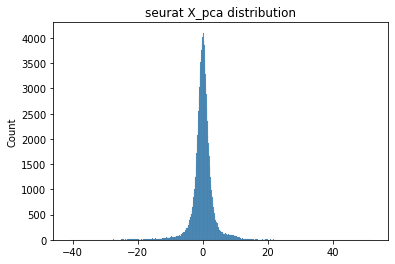

In [7]:
X_pca_arr = seurat_X_pca.to_numpy().flatten()
sns.histplot(X_pca_arr).set_title("seurat X_pca distribution")
plt.show()
# sns.histplot(seurat_residual_mean.to_numpy().flatten()).set_title("seurat residual mean")
# plt.show()
# sns.histplot(seurat_residual_variance.to_numpy().flatten()).set_title("seurat residual variance")
# plt.show()

## Obtain seurat adata and set correspondin fields for next comparison steps

In [8]:
seurat_adata = dyn.sample_data.zebrafish()
dyn.preprocessing.unique_var_obs_adata(seurat_adata)
dyn.preprocessing.filter_cells_by_outliers(seurat_adata)
print(seurat_X_pca.shape)
print(seurat_adata.shape)
print(set(seurat_X_pca.index) - set(seurat_adata.obs_names))
print(set(seurat_adata.obs_names) - set(seurat_X_pca.index))


|-----> Downloading data to ./data/zebrafish.h5ad
|-----------> filtering cells by layer:X
|-----------> filtering cells by layer:spliced
|-----------> filtering cells by layer:unspliced
|-----> skip filtering by layer:protein as it is not in adata.
|-----> <insert> pass_basic_filter to obs in AnnData Object.
|-----------> inplace subsetting adata by filtered cells
(4167, 50)
(4167, 16940)
set()
set()


### Reorder seurat_X_pca index in adata obs_name order and set to X_pca

In [9]:

seurat_adata.obsm["X_pca"] = seurat_X_pca.loc[seurat_adata.obs_names, :].to_numpy()


In [10]:
print(seurat_X_pca.shape)
print(dyn_adata_preprocessor.shape)

(4167, 50)
(4167, 2000)


### compare the shape of X_pca

In [11]:
print(dyn_adata_preprocessor.obsm["X_pca"].shape)
seurat_adata.obsm["X_pca"].shape


(4167, 50)


(4167, 50)

In [12]:
dyn_adata_preprocessor.var.columns

Index(['pass_basic_filter', 'score', 'log_m', 'log_cv', 'frac', 'use_for_pca',
       'gene_highly_variable', 'Intercept_sct', 'log_umi_sct', 'theta_sct',
       'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct',
       'genes_step1_sct', 'log10_gmean_sct'],
      dtype='object')

In [13]:
dyn_adata_preprocessor.var["genes_step1_sct"].sum()

1980

### distribution comparisons

<AxesSubplot:>

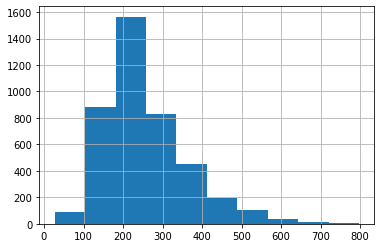

In [14]:
dyn_adata_preprocessor.obs["gene_sct"].hist()

No handles with labels found to put in legend.


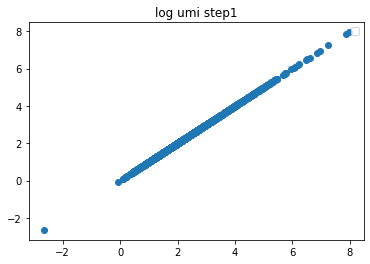

No handles with labels found to put in legend.


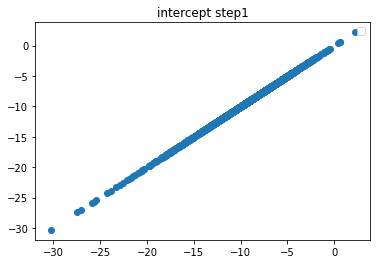

No handles with labels found to put in legend.


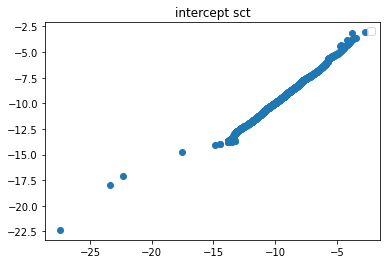

No handles with labels found to put in legend.


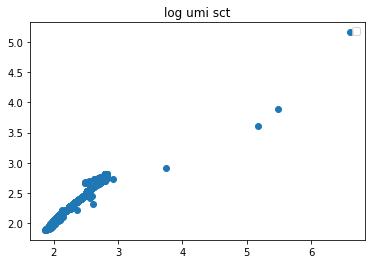

No handles with labels found to put in legend.


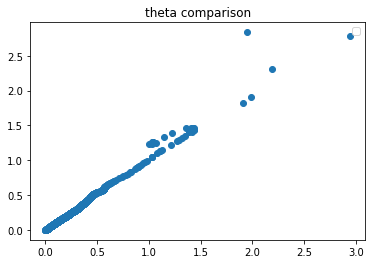

No handles with labels found to put in legend.


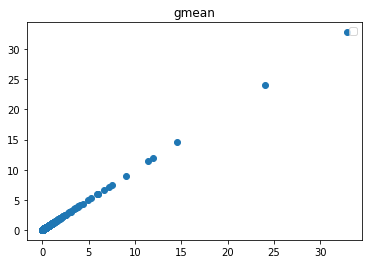

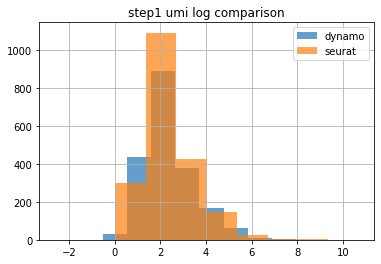

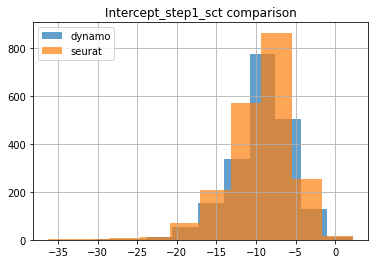

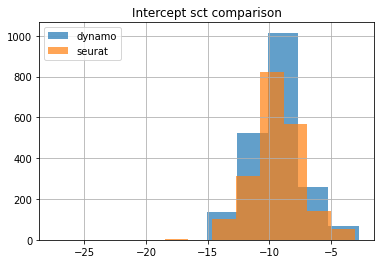

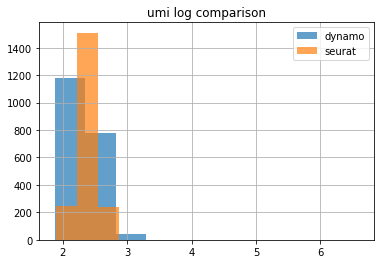

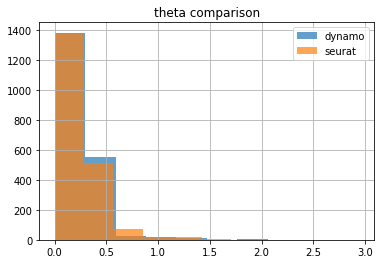

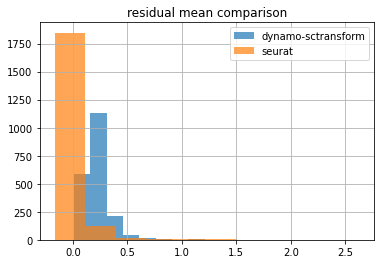

<Figure size 432x288 with 0 Axes>

In [36]:
def benchmark_plots(dyn_adata_preprocessor, seurat_features):
    genes = seurat_features["Unnamed: 0"]
    plt.scatter(dyn_adata_preprocessor[:, genes].var["log_umi_step1_sct"], seurat_features["step1_log_umi"])
    plt.title("log umi step1")
    plt.legend()
    plt.show()
    plt.clf()

    plt.scatter(dyn_adata_preprocessor[:, genes].var["Intercept_step1_sct"], seurat_features["step1_(Intercept)"])
    plt.title("intercept step1")
    plt.legend()
    plt.show()
    plt.clf()

    plt.scatter(dyn_adata_preprocessor[:, genes].var["Intercept_sct"], seurat_features["(Intercept)"])
    plt.title("intercept sct")
    plt.legend()
    plt.show()
    plt.clf()

    plt.scatter(dyn_adata_preprocessor[:, genes].var["log_umi_sct"], seurat_features["log_umi"])
    plt.title("log umi sct")
    plt.legend()
    plt.show()
    plt.clf()

    plt.scatter(dyn_adata_preprocessor[:, genes].var["theta_sct"], seurat_features["theta"])
    plt.title("theta comparison")
    plt.legend()
    plt.show()
    plt.clf()

    plt.scatter(10**dyn_adata_preprocessor[:, genes].var["log10_gmean_sct"], seurat_features["gmean"])
    plt.title("gmean")
    plt.legend()
    plt.show()
    plt.clf()
    
    alpha = 0.7
    dyn_adata_preprocessor.var["log_umi_step1_sct"].hist(label="dynamo", alpha=alpha)
    seurat_features["step1_log_umi"].hist(label="seurat", alpha=alpha)
    plt.title("step1 umi log comparison")
    plt.legend()
    plt.show()
    plt.clf()

    dyn_adata_preprocessor.var["Intercept_step1_sct"].hist(label="dynamo", alpha=alpha)
    seurat_features["step1_(Intercept)"].hist(label="seurat", alpha=alpha)
    plt.title("Intercept_step1_sct comparison")
    plt.legend()
    plt.show()
    plt.clf()

    dyn_adata_preprocessor.var["Intercept_sct"].hist(label="dynamo", alpha=alpha)
    seurat_features["(Intercept)"].hist(label="seurat", alpha=alpha)
    plt.title("Intercept sct comparison")
    plt.legend()
    plt.show()
    plt.clf()


    dyn_adata_preprocessor.var["log_umi_sct"].hist(label="dynamo", alpha=alpha)
    seurat_features["log_umi"].hist(label="seurat", alpha=alpha)
    plt.title("umi log comparison")
    plt.legend()
    plt.show()
    plt.clf()

    dyn_adata_preprocessor.var["theta_sct"].hist(label="dynamo", alpha=alpha)
    seurat_features["theta"].hist(label="seurat", alpha=alpha)
    plt.title("theta comparison")
    plt.legend()
    plt.show()
    plt.clf()



    pd.Series(np.array(dyn_adata_preprocessor.X.mean(0)).flatten()).hist(label="dynamo-sctransform", alpha=alpha) # , figsize=(20,20))
    # pd.Series(np.array(adata_origin.X.mean(0)).flatten()).hist(label="dynamo-origin", alpha=alpha)
    seurat_features["residual_mean"].hist(label="seurat", alpha=alpha, bins=10)
    plt.title("residual mean comparison")
    plt.legend()
    plt.show()
    plt.clf()
benchmark_plots(dyn_adata_preprocessor, seurat_features)

In [17]:
seurat_features["step1_log_umi"]

0       1.801491
1       2.975170
2       2.740283
3       2.679961
4       2.986581
          ...   
1995    2.511955
1996    3.188149
1997    4.188380
1998    3.726043
1999    3.339615
Name: step1_log_umi, Length: 2000, dtype: float64

min len: 208350
min len: 125010


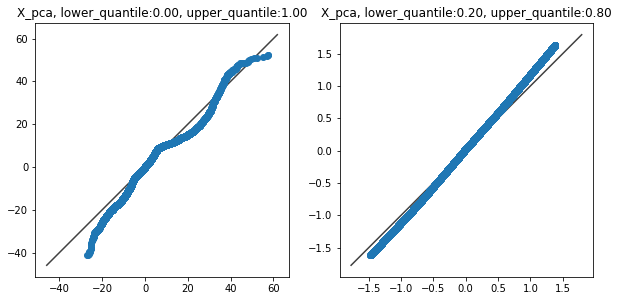

In [22]:
fig, axes = plt.subplots(1,2, figsize=(10, 20))
key = "X_pca"
use_for_pca = list(
    set(dyn_adata_preprocessor.var_names[dyn_adata_preprocessor.var["use_for_pca"]]))

lower_quantile = 0
upper_quantile = 1
def cmp_X_pca(lower_quantile, upper_quantile, ax):
    x_data = np.sort( dyn_adata_preprocessor.obsm[key].flatten())
    x_data = x_data[np.logical_and(np.quantile(x_data, lower_quantile) <= x_data, x_data <= np.quantile(x_data, upper_quantile))]
    y_data = np.sort(seurat_adata[dyn_adata_preprocessor.obs_names, :].obsm[key].flatten())
    y_data = y_data[np.logical_and(np.quantile(y_data, lower_quantile) <= y_data, y_data <= np.quantile(y_data, upper_quantile))]

    # maybe there is <=3 shape difference
    min_len = min(len(x_data), len(y_data))
    print("min len:", min_len)
    ax.scatter(x_data[:min_len],
                    y_data[:min_len])  # , title="X_pca comparison")

    ax.set_title(key + ", lower_quantile:%.2f, upper_quantile:%.2f" %(lower_quantile, upper_quantile))
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')

cmp_X_pca(0, 1, axes[0])

cmp_X_pca(0.2, 0.8, axes[1])





<Figure size 600x400 with 0 Axes>

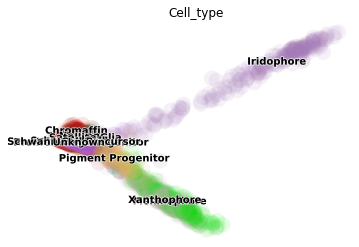

<Figure size 600x400 with 0 Axes>

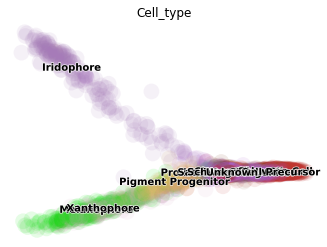

In [19]:

dyn.pl.scatters(dyn_adata_preprocessor, basis="pca", color="Cell_type")
dyn.pl.scatters(seurat_adata, basis="pca", color="Cell_type")


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [234.0027s]


<Figure size 1000x1000 with 0 Axes>

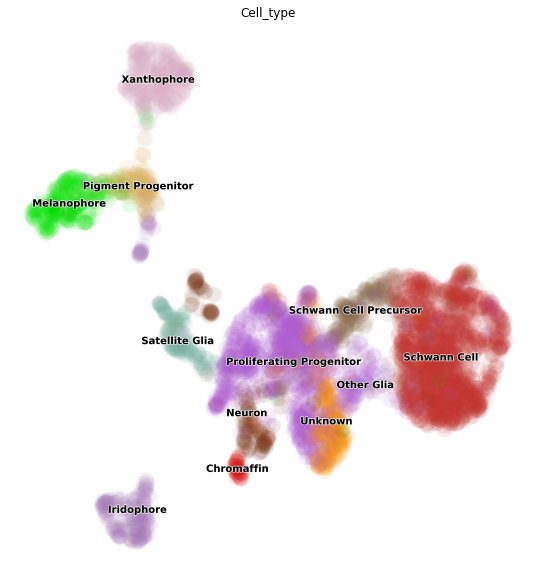

In [20]:

dyn.tl.reduceDimension(seurat_adata, basis="pca")
dyn.pl.umap(seurat_adata, color="Cell_type", figsize=(10, 10))


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [15.3168s]


<Figure size 1000x1000 with 0 Axes>

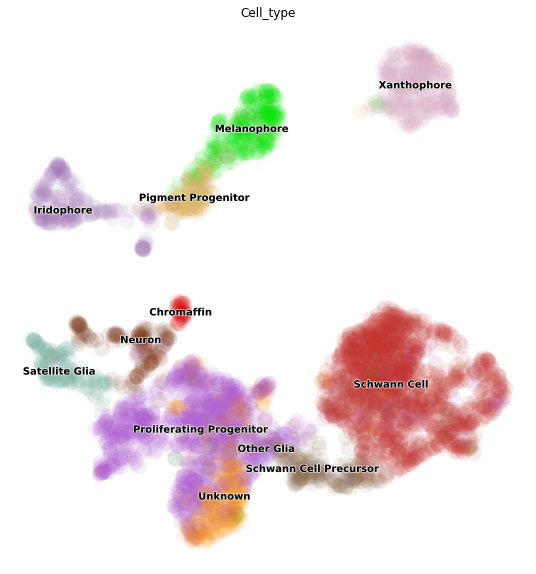

In [21]:
dyn.tl.reduceDimension(dyn_adata_preprocessor, basis="pca")
dyn.pl.umap(dyn_adata_preprocessor, color="Cell_type", figsize=(10, 10), affine_transform_degree=270)
